In [1]:
import lightning as L

In [7]:
from data_loader.CIFAR100 import CIFAR100

L.pytorch.seed_everything(42)
dm = CIFAR100(batch_size=64, data_path="./data/cifar100/")
dm.prepare_data()
dm.setup()

Seed set to 42


100%|██████████| 169001437/169001437 [00:33<00:00, 4988023.20it/s]


Extracting ./data/cifar100/cifar-100-python.tar.gz to ./data/cifar100/


In [3]:
len(dm.train)

45000

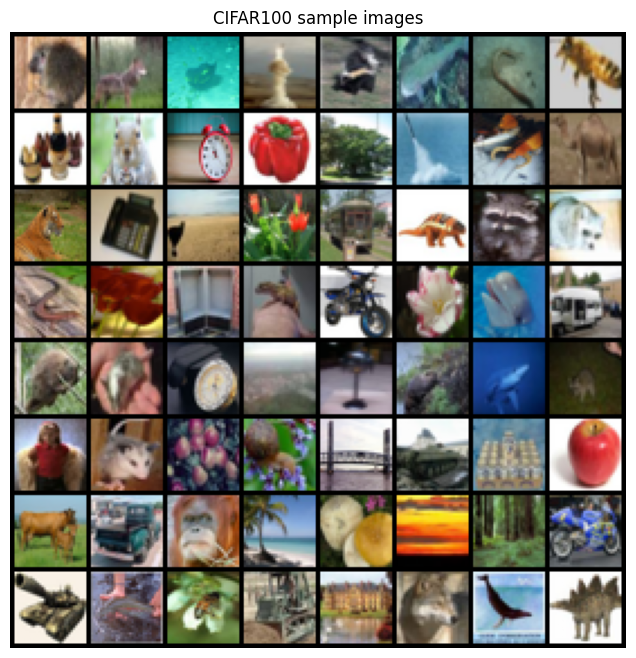

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torchvision

for images,labels in dm.train_dataloader():
  break # for visualization purposes, we only need the first batch

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("CIFAR100 sample images")
plt.imshow(
  np.transpose(
    torchvision.utils.make_grid(images[:64], padding=2, normalize=True).cpu(),
    (1, 2, 0)
  )
)
plt.show()